# Magnitude of interactions influencing selection into samples

Biological interactions tend to be quite modest but interactions influencing selection mechanisms may be larger. Use Fry et al (2017) estimates of sample selection to estimate plausible magnitudes of interaction effects influencing selection into samples, based on differential incidence rates by age in the UK Biobank and in the general population.

In [26]:
library(here)
library(data.table)
library(janitor)
library(tidyr)
library(dplyr)
library(ggplot2)

Using results from:

Fry et al 2017 AJE. "Comparison of Sociodemographic and Health-Related Characteristics of UK Biobank Participants With Those of the General Population"

Get incidence rates for different cancers from Web Table 5 https://pmc.ncbi.nlm.nih.gov/articles/instance/5860371/bin/kwx246littlejohnswebmaterialfinal.pdf

This has incidence rates per 100,000 person-years in UK Biobank and in the general population. To obtain the estimate of the odds ratio of selection divide the two rates

In [23]:
dat <- fread(here("selection-ukb-estimation/data.csv")) %>% janitor::clean_names()
dat

cancer_type,age_group,men_uk_biobank,men_general_population,women_uk_biobank,women_general_population
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
All cancer excluding non-melanoma skin cancer,45-49,177.7,201.0,438.0,408.2
All cancer excluding non-melanoma skin cancer,50-54,330.5,356.9,514.7,551.2
All cancer excluding non-melanoma skin cancer,55-59,621.6,670.7,615.8,703.4
All cancer excluding non-melanoma skin cancer,60-64,1011.9,1146.8,835.0,963.5
All cancer excluding non-melanoma skin cancer,65-69,1644.1,1706.3,1062.4,1241.2
All cancer excluding non-melanoma skin cancer,70-74,2037.5,2310.9,1209.2,1477.3
Prostate,45-49,23.6,17.0,NA,NA
Prostate,50-54,83.2,63.2,NA,NA
Prostate,55-59,219.4,173.4,NA,NA


In [10]:
dat_long <- pivot_longer(dat, cols = c(men_uk_biobank, men_general_population, women_uk_biobank,    women_general_population)) %>% 
    mutate(name = gsub("uk_biobank", "ukb", name),
           name = gsub("general_population", "genpop", name)) %>%
    separate(name, into = c("sex", "population"), sep = "_") %>% 
    pivot_wider(names_from = population, values_from = value) %>%
    mutate(or = ukb / genpop)

Plot incidence rates by age and sex for each cancer type

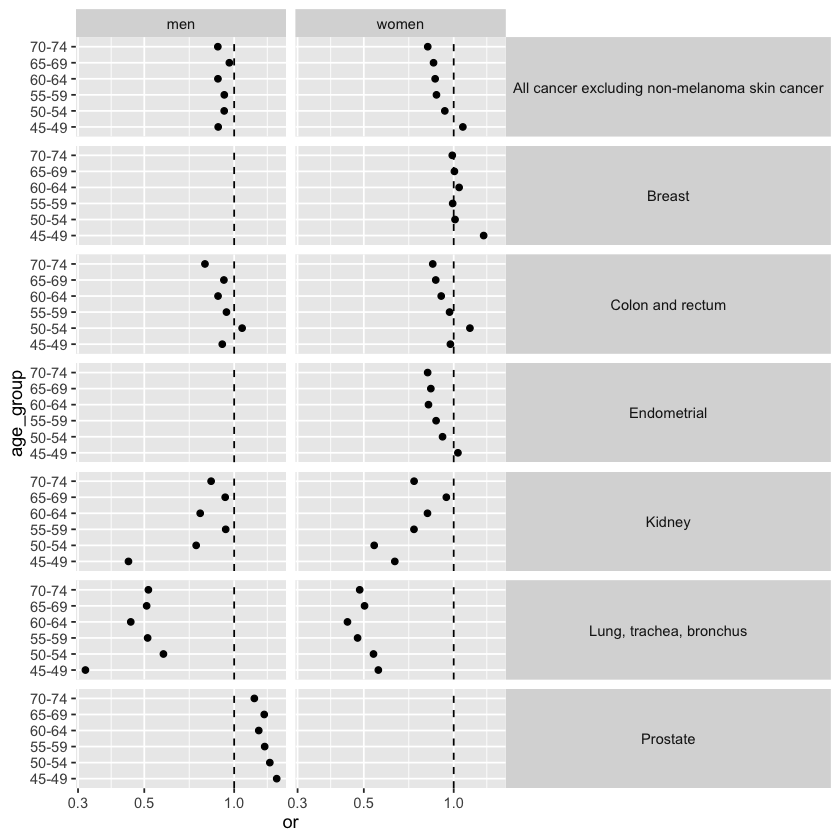

In [20]:
dat_long %>%
    ggplot(aes(y = age_group, x = or)) +
    geom_point() +
    scale_x_log10() +
    geom_vline(xintercept = 1, linetype = "dashed") +
    facet_grid(cancer_type ~ sex) +
    theme(strip.text.y = element_text(angle=0), legend="none")

The estimates change quite a bit by age and perhaps less so by sex.

Estimate the interaction effect using the Ratio of Odds Ratios method (ROR), comparing the OR in the youngest age group to the OR in the oldest age group.

In [22]:
group_by(dat_long, cancer_type, sex) %>%
    filter(age_group %in% c("70-74", "45-49")) %>%
    summarise(
        or_mean = exp(mean(log(or))),
        or_age_interaction = first(or) / last(or)) %>% ungroup()

`summarise()` has grouped output by 'cancer_type'. You can override using the
`.groups` argument.


cancer_type,sex,or_mean,or_age_interaction
<chr>,<chr>,<dbl>,<dbl>
All cancer excluding non-melanoma skin cancer,men,0.8828846,1.0027090
All cancer excluding non-melanoma skin cancer,women,0.9371633,1.3109064
Breast,men,NA,NA
Breast,women,1.1161961,1.2737761
Colon and rectum,men,0.8534566,1.1427748
Colon and rectum,women,0.9106263,1.1457870
Endometrial,men,NA,NA
Endometrial,women,0.9191963,1.2630854
Kidney,men,0.6087300,0.5287111


- Overall this illustrates that the interaction for OR for selection can be quite large. 
- Note that for breast cancer it appears that selection into the sample *increases* with age. This is the opposite direction to what is hypothesised by Schooling et al, where they suggest that mortality leads to less selection at older ages.